This notebook makes projections for GECCO and other MeV gamma-ray telescopes.

## Setup and utils

In [3]:
import jupyter_beeper


beeper = jupyter_beeper.Beeper()

def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

In [405]:
%load_ext autoreload
%autoreload 2

from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from collections import defaultdict
from scipy.interpolate import interp1d
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import (
    sv_inv_MeV_to_cm3_per_s,
    muon_mass as m_mu,
    charged_pion_mass as m_pi,
    neutral_pion_mass as m_pi0,
    electron_mass as m_e
)
from hazma.gamma_ray_parameters import *

from hazma.theory import TheoryDec
from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannelAnn, SingleChannelDec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [478]:
# Other constants
T_obs_nt = 1e6  # s
v_mw = 1e-3
x_kd = 1e-6  # DM mass divided by T_kd

# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)
# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}


def set_m_med(model, m_med):
    if hasattr(model, "ms"):
        model.ms = m_med
    elif hasattr(model, "mv"):
        model.mv = m_med
    else:
        raise AttributeError("could not determine mediator name")


def get_constraints(
    model,
    mxs,
    m_meds=None,
    nt_targets={},
    existing=["comptel", "egret", "fermi", "integral"],
    cmb=True
):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i in trange(len(mxs)):
        model.mx = mxs[i]
        if m_meds is not None:
            set_m_med(model, m_meds[i])

        # Constraints from existing data
        for telescope in existing:
            constraints[telescope][i] = model.binned_limit(eval(f"{telescope}_diffuse"))

        # Projections
        for key, (target, bg_model) in nt_targets.items():
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco,
                energy_res_gecco,
                T_obs_nt,
                target,
                bg_model,
            )

        # TODO: what x_kd value should be used for decaying DM?
        if cmb:
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("comptel", "COMPTEL")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("integral", "INTEGRAL ")
    label = label.replace("gecco_", "GECCO ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def plot_existing(ax, mxs, svs, label, color, y2=1):
    """
    Plots an existing constraint.
    """
    if label == r"CMB ($s$-wave)":
        ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=label)
    elif label == r"CMB ($p$-wave)":
        v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
        ax.plot(
            mxs, svs * (v_mw / v_cmbs)**2, "--k", linewidth=1, label=label
        )
    else:
        ax.fill_between(mxs, svs, y2=y2, label=label, alpha=0.2, color=color)
        ax.loglog(mxs, svs, "-", color=color, linewidth=0.5)

# Global formatting
colors = {
    "comptel": mpl_colors[0],
    "egret": mpl_colors[1],
    "fermi": mpl_colors[2],
    "integral": mpl_colors[3],
    "gc_ein_1_arcmin_cone_optimistic": mpl_colors[4],
    "gc_ein_5_deg_optimistic": mpl_colors[4],
    "gc_nfw_1_arcmin_cone": mpl_colors[5],
    "gc_nfw_5_deg": mpl_colors[5],
    "m31_nfw_1_arcmin_cone": mpl_colors[6],
    "m31_nfw_5_deg": mpl_colors[6],
    "draco_nfw_1_arcmin_cone": mpl_colors[7],
    "draco_nfw_5_deg": mpl_colors[7],
}

linestyles = {
    "gc_ein_1_arcmin_cone_optimistic": "-",
    "gc_ein_5_deg_optimistic": "-",
    "gc_nfw_1_arcmin_cone": "--",
    "gc_nfw_5_deg": "--",
    "m31_nfw_1_arcmin_cone": ":",
    "m31_nfw_5_deg": ":",
    "draco_nfw_1_arcmin_cone": ":",
    "draco_nfw_5_deg": ":",
}

# Base figure size
fig_dim = 4
mpl_colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Model-independent annihilation constraints

### Compute

In [416]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs = {
    "e e": np.geomspace(m_e, 10 * 1e3, n_mxs),
    "g g": np.geomspace(6e-2, 1e1, n_mxs),
    "mu mu": np.geomspace(m_mu, 10 * 1e3, n_mxs),
    "pi pi": np.geomspace(m_pi, 10 * 1e3, n_mxs),
}

# Compute
svs = {}
for fs in fss:
    model = SingleChannelAnn(1., fs, 1.)
    svs[fs] = get_constraints(model, mxs[fs], nt_targets=nt_targets_ann)

# Clean up any extremely weak constraints
for key in svs:
    for k in svs[key]:
        svs[key][k][svs[key][k] > 1] = np.inf

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:169: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [435]:
# Save constraints
np.savez("data/single_channel_ann/svs.npz", **svs)
np.savez("data/single_channel_ann/mxs.npz", **mxs)

### Plot

In [439]:
svs = dict(
    np.load("data/single_channel_ann/svs.npz", allow_pickle=True)
)
svs = {k: v.item() for k, v in svs.items()}
mxs = dict(
    np.load("data/single_channel_ann/mxs.npz", allow_pickle=True)
)

y_lims = {
    "e e": (1e-33, 1e-22),
    "g g": (1e-37, 1e-28),
    "mu mu": (1e-30, 1e-22),
    "pi pi": (1e-30, 1e-22),
    "pi0 pi0": (1e-30, 1e-22),
    "pi0 g": (1e-30, 1e-22),
}

In [448]:
def plot_integral_secondary(ax, fs, base_dir="data/integral/"):
    if fs not in ["e e", "mu mu", "pi pi"]:
        return
    
    es, svs = np.loadtxt(
        f"{os.path.join(base_dir, fs.replace(' ', '_'))}.csv", unpack=True
    )
    ax.plot(es, svs, ":r")

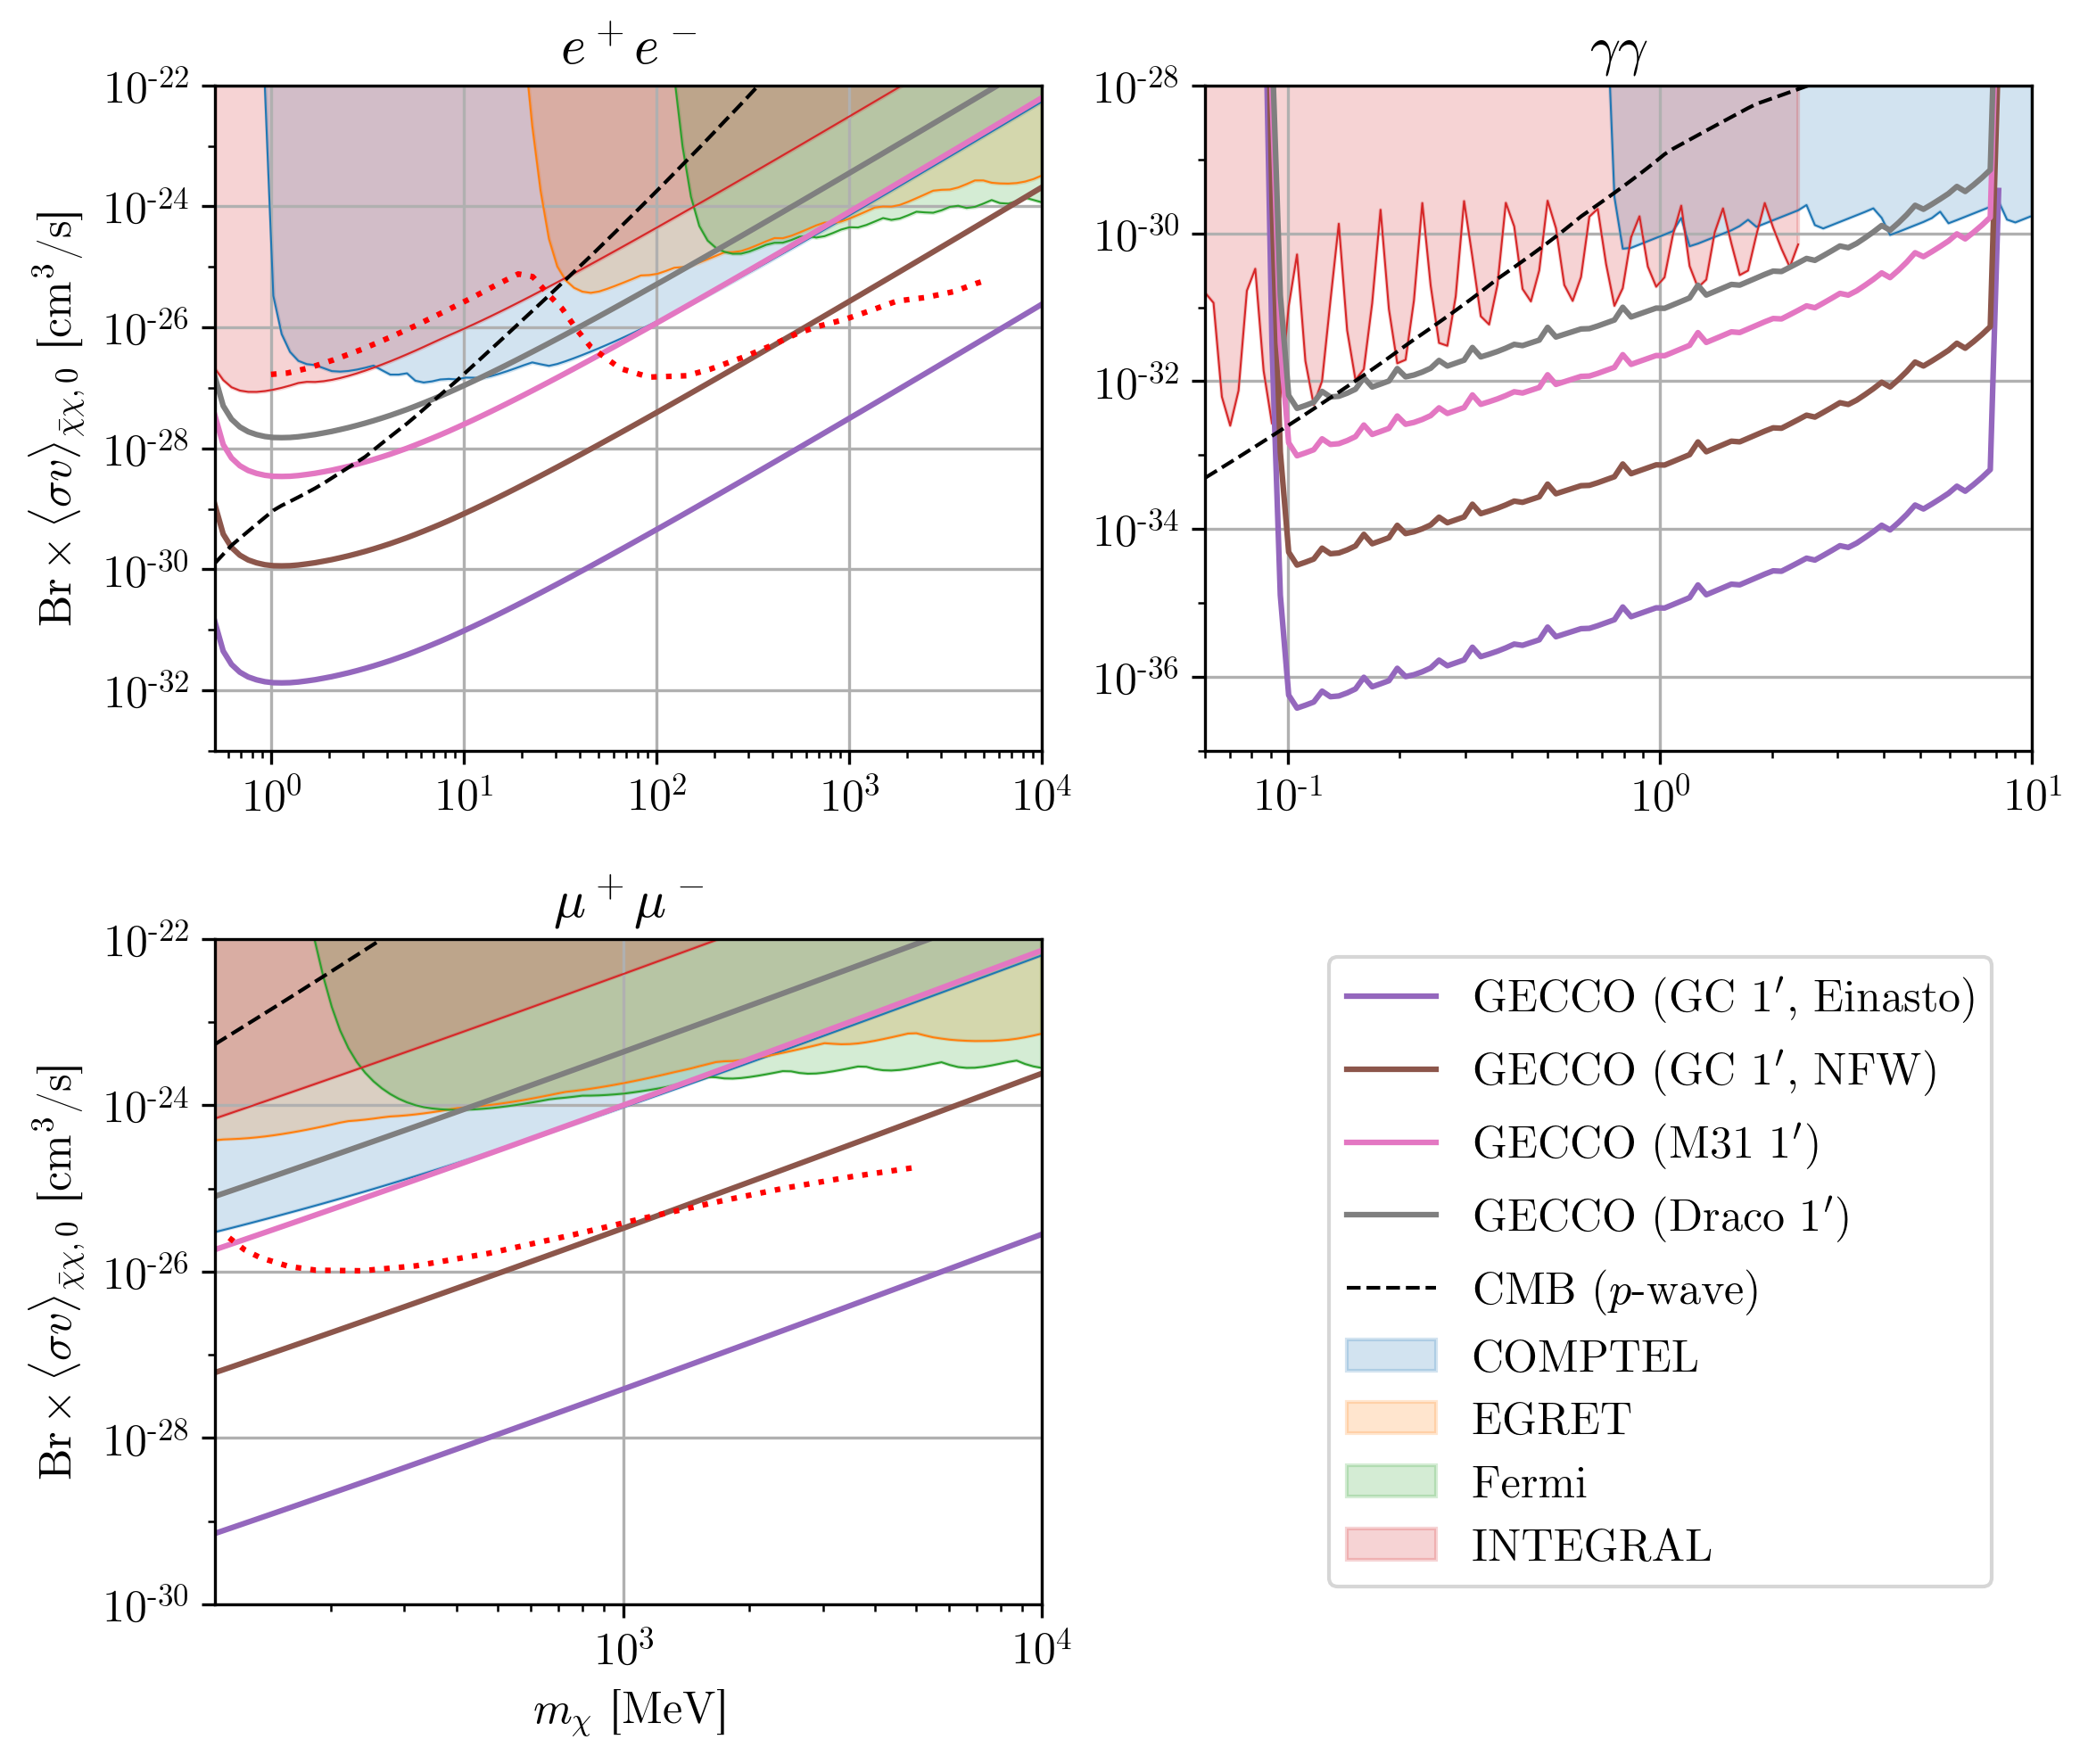

In [449]:
fig, axes = plt.subplots(2, 2, figsize=(fig_dim * 2, fig_dim * 2 * 0.85))

for fs, ax in zip(fss, axes.flatten()):
    for key, color in zip(svs[fs], mpl_colors):
        if key == "cmb":
#             label = r"CMB ($s$-wave)"
            label = r"CMB ($p$-wave)"
        else:
            label = get_constraint_label(key)

        if "gecco" not in key:
            plot_existing(ax, mxs[fs], svs[fs][key], label, color)
        else:
            ax.loglog(mxs[fs], svs[fs][key], label=label, color=color)
    
    plot_integral_secondary(ax, fs)

# Formatting
for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # Ticks
    ax.yaxis.set_major_locator(LogLocator(base=100, numticks=20))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=20))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')

for ax in axes[-1, :]:
    ax.set_xlabel(r"$m_\chi$ [MeV]")

for ax in axes[:, 0]:
    ax.set_ylabel(
        r"$\mathrm{Br} \times \langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
    )

fig.tight_layout()

axes[-1, -1].set_visible(False)
axes[-1, 0].legend(
    loc="center left", bbox_to_anchor=(1.32, 0.5)
)

# fig.savefig("figures/single_channel_ann.pdf", bbox_inches="tight")

## Model-independent decay constraints

### Compute

In [ ]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs = {
    "e e": np.geomspace(2 * m_e, 1e4, n_mxs),
    "g g": np.geomspace(1.2e-1, 2e1, n_mxs),
    "mu mu": np.geomspace(2 * m_mu, 1e4, n_mxs),
    "pi pi": np.geomspace(2 * m_pi, 1e4, n_mxs),
}

# Compute
gammas = {}
for fs in fss:
    model = SingleChannelDec(1., fs, 1.)
    gammas[fs] = get_constraints(
        model, mxs[fs], nt_targets=nt_targets_dec, cmb=False
    )

# Clean up any extremely weak constraints
for key in gammas:
    for k in gammas[key]:
        gammas[key][k][gammas[key][k] > 1] = np.inf

In [188]:
# Save constraints
np.savez("data/single_channel_dec/gammas.npz", **gammas)
np.savez("data/single_channel_dec/mxs.npz", **mxs)

### Plot

In [437]:
gammas = dict(
    np.load("data/single_channel_dec/gammas.npz", allow_pickle=True)
)
gammas = {k: v.item() for k, v in gammas.items()}
mxs = dict(
    np.load("data/single_channel_dec/mxs.npz", allow_pickle=True)
)

y_lims = {
    "e e": (1e22, 1e27),
    "g g": (1e25, 1e31),
    "mu mu": (1e22, 1e26),
    "pi pi": (1e22, 1e26),
}

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


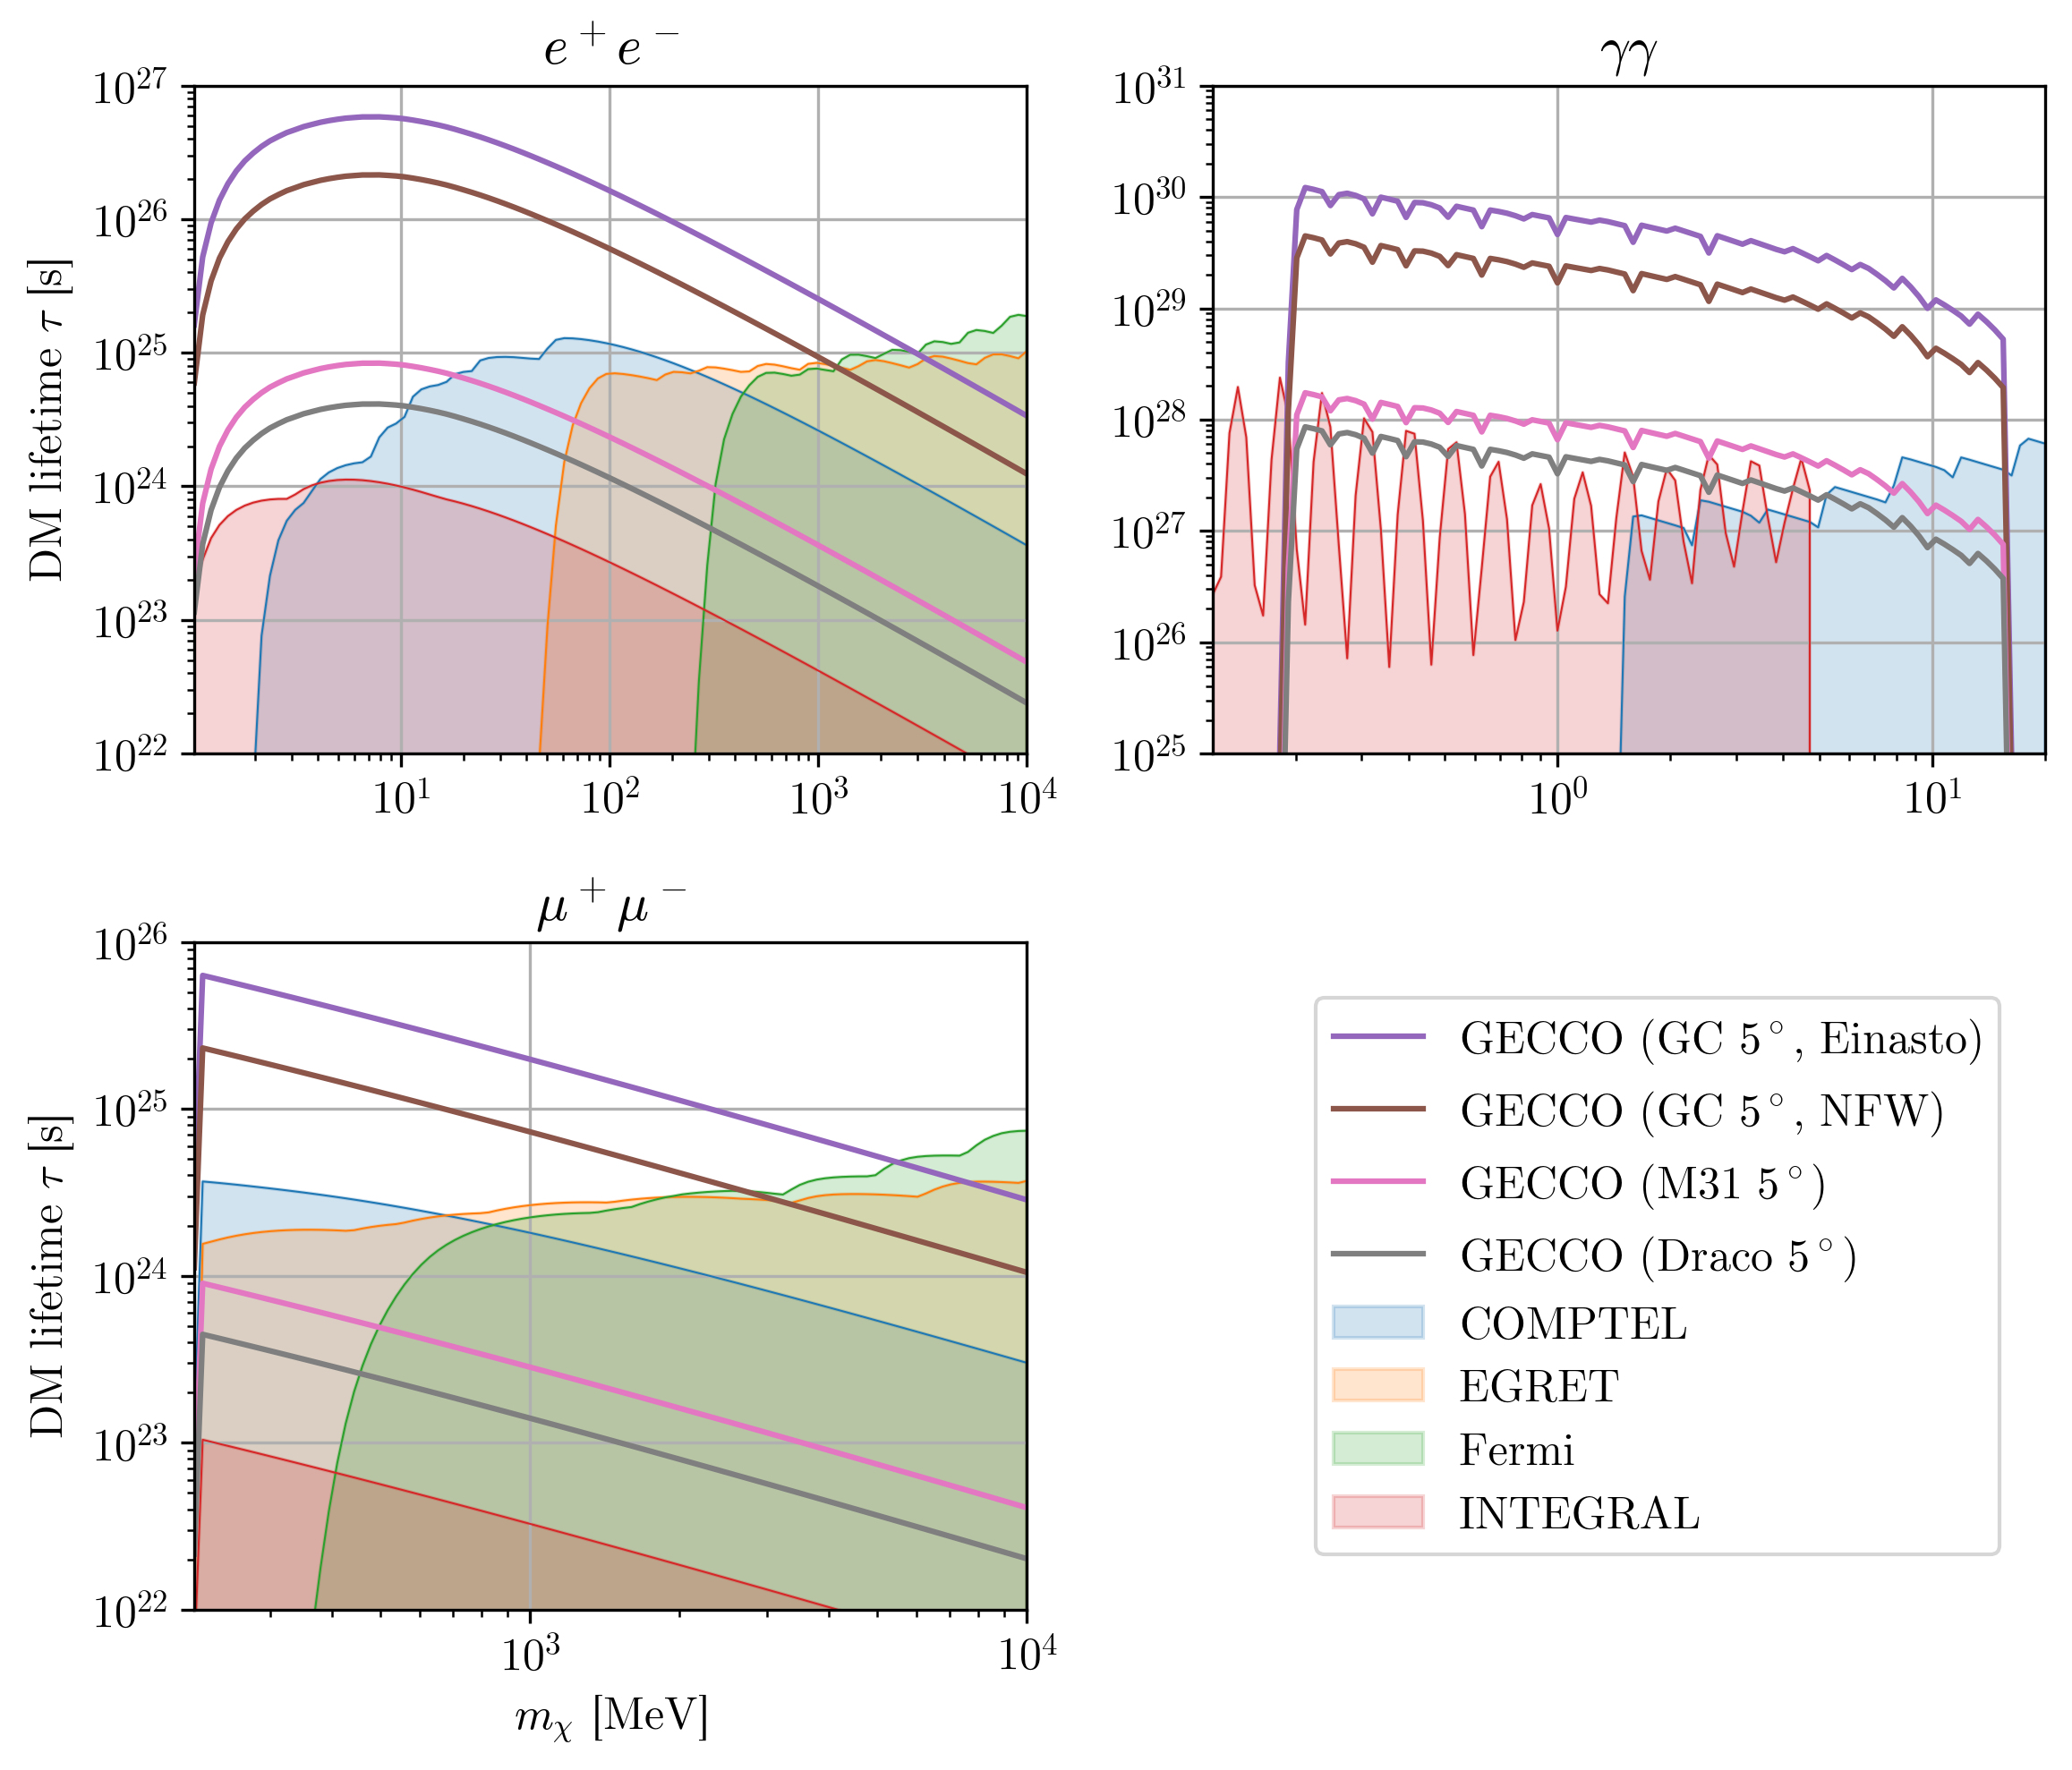

In [438]:
fig, axes = plt.subplots(2, 2, figsize=(fig_dim * 2, fig_dim * 2 * 0.85))

for fs, ax in zip(fss, axes.flatten()):
    for key, color in zip(gammas[fs], mpl_colors):
        if key == "cmb":
#             label = r"CMB ($s$-wave)"
            label = r"CMB ($p$-wave)"
        else:
            label = get_constraint_label(key)

        if "gecco" not in key:
            plot_existing(ax, mxs[fs], 1 / gammas[fs][key], label, color)
        else:
            ax.loglog(mxs[fs], 1 / gammas[fs][key], label=label, color=color)

# Formatting
for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')

for ax in axes[-1, :]:
    ax.set_xlabel(r"$m_\chi$ [MeV]")

for ax in axes[:, 0]:
    ax.set_ylabel(r"DM lifetime $\tau$ [s]")

fig.tight_layout()

axes[-1, -1].set_visible(False)
axes[-1, 0].legend(
    loc="center left", bbox_to_anchor=(1.32, 0.5)
)

fig.savefig("figures/single_channel_dec.pdf", bbox_inches="tight")

## Higgs portal model

### Check pheno constraints on $\sin\theta$

In [344]:
def get_constr_label(name):
    """
    Labels for pheno constraints.
    """
    name = f"${name}$"
    label = name.replace("->", "\\to")
    label = label.replace("e e", "e^+ e^-")
    label = label.replace("mu mu", "\mu^+ \mu^-")
    label = label.replace(" pi0", " \pi^0")
    label = label.replace(" pi", " \pi")
    label = label.replace("k ", "K ")
    label = label.replace("kl ", "K_L ")
    label = label.replace(" invis", "\, \mathrm{invis.}")
    label = label.replace("charm", "\mathrm{CHARM}")
    return label

In [345]:
sm = HiggsPortal(mx=150, ms=1e3, gsxx=0.001, stheta=0.1)
mss = np.linspace(0.1, 1e3, 60)
sthetas = np.geomspace(1e-5, 1e0, 50)
constrs = sm.constrain("ms", mss, "stheta", sthetas, "image")

<ipython-input-348-d20c6b477cff>:2: UserWarning: linewidths is ignored by contourf
  plt.contourf(


Text(0.5, 1.0, '$m_\\chi = 150$ MeV')

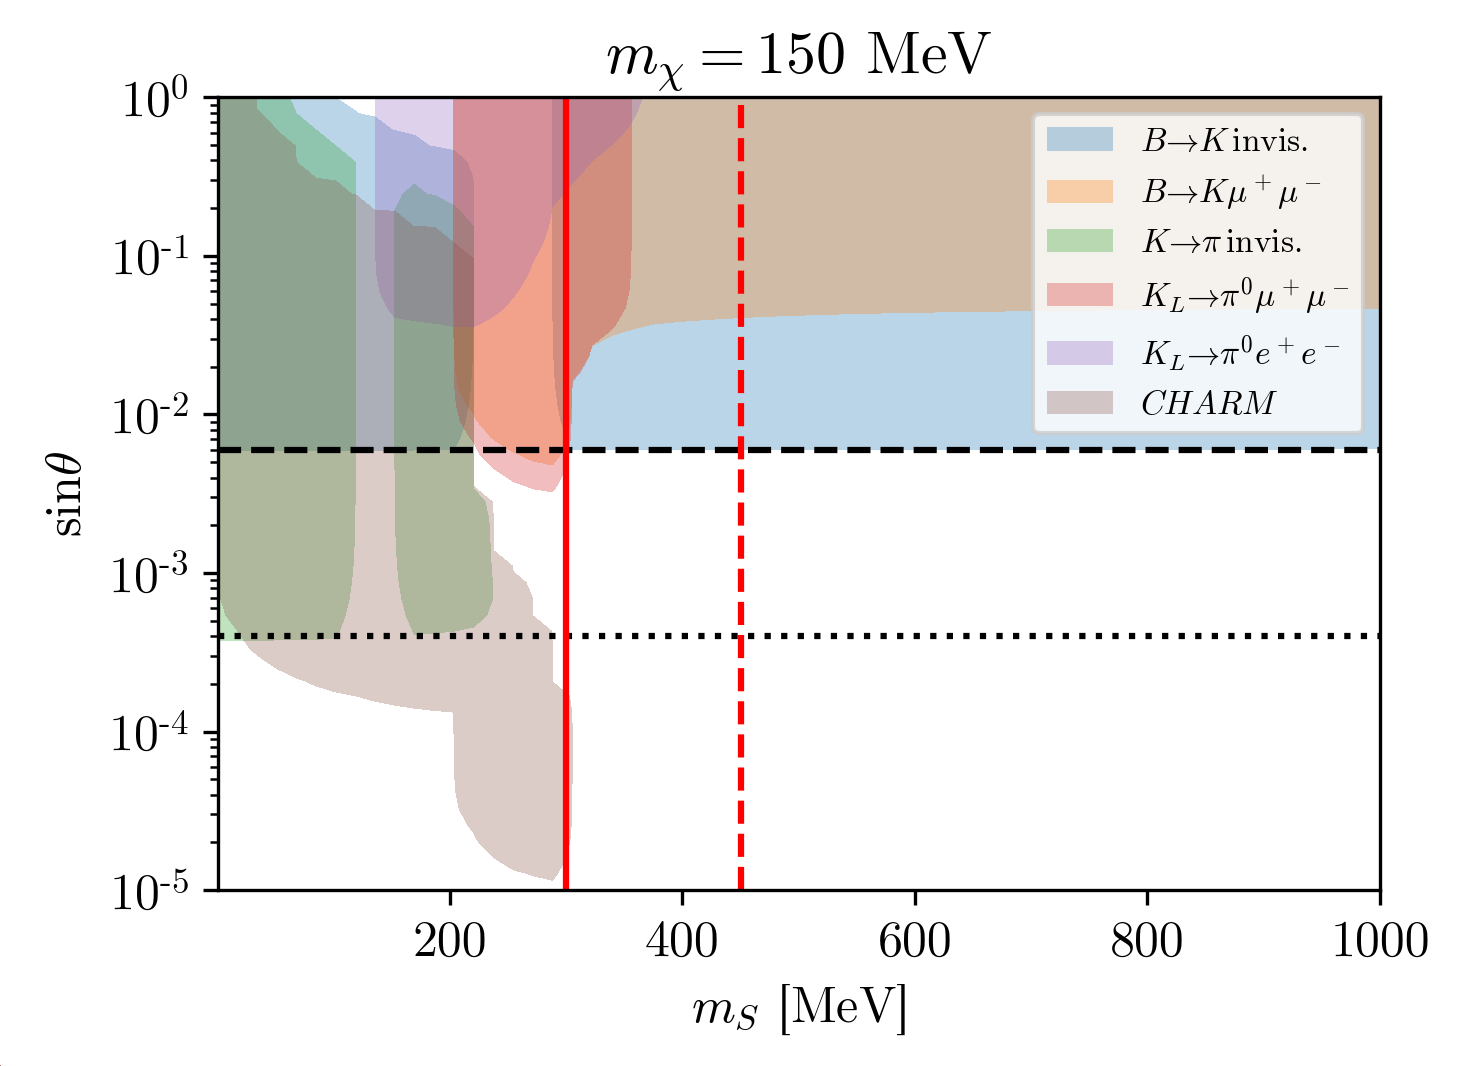

In [348]:
for (name, constr), color in zip(constrs.items(), mpl_colors):
    plt.contourf(
        mss, sthetas, constr, levels=[-1e100, 0], colors=[color], linewidths=[1],
        alpha=0.3
    )
    proxy = plt.Rectangle(
        (0, 0), 1, 1, fc=color, label=get_constr_label(name), alpha=0.3
    )
    plt.gca().patches += [proxy]

plt.axhline(6e-3, color="k", linestyle="--")
plt.axhline(4e-4, color="k", linestyle=":")
plt.axvline(2 * sm.mx, color="r", linestyle="-")
plt.axvline(3 * sm.mx, color="r", linestyle="--")
plt.axvline(10 * sm.mx, color="r", linestyle=":")

plt.xlim(0.1, 1e3)
plt.yscale("log")
plt.xlabel(r"$m_S$ [MeV]")
plt.ylabel(r"$\sin \theta$")
plt.legend(fontsize=8)#, loc="lower right")
plt.title(r"$m_\chi = %g$ MeV" % sm.mx)

### Compute

In [388]:
ms_over_mxs = [0.1, 0.5, 2]
mxs = [np.geomspace(0.1, 250, 100) for _ in ms_over_mxs]
mss = [mx * ms_over_mx for mx, ms_over_mx in zip(mxs, ms_over_mxs)]
models = [HiggsPortal(mx=1, ms=1, gsxx=1, stheta=0.1) for _ in ms_over_mxs]

svs = [{} for _ in mxs]
for i in range(len(mxs)):
    svs[i] = get_constraints(models[i], mxs[i], mss[i], nt_targets_ann)
    # Clean up any extremely weak constraints
    for key in svs[i]:
        svs[i][key][svs[i][key] > 1] = np.inf

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_spectra.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 2.0 * dnde_decay_s(e_gams, e_s, ms, pw_array, fs)


In [389]:
beep()

In [390]:
# Save constraints
np.savez("data/higgs_portal/svs.npz", svs=svs)
np.savez("data/higgs_portal/mxs.npz", mxs=mxs)
np.savez("data/higgs_portal/mss.npz", mss=mss)

### Plot

In [454]:
svs = list(np.load("data/higgs_portal/svs.npz", allow_pickle=True)["svs"])
mxs = np.load("data/higgs_portal/mxs.npz")["mxs"]
mss = np.load("data/higgs_portal/mss.npz")["mss"]

In [455]:
def get_svs_pheno(model, mxs, mss, stheta, vx=1e-3):
    """
    Converts pheno constraint on stheta to <sigma v>.
    """
    svs = np.zeros(len(mxs))
    for i in range(len(mxs)):
        model.stheta = stheta(mxs[i], mss[i]) # pheno constraint
        model.mx = mxs[i]
        if mss[i] is not None:
            set_m_med(model, mss[i])

        # Approximate the thermal average as sigma * v
        sv = model.annihilation_cross_sections(
            2 * model.mx * (1 + 0.5 * vx**2)
        )["total"] * vx
        svs[i] = sv * sv_inv_MeV_to_cm3_per_s

    return svs

In [456]:
titles = [
    r"$m_S = m_\chi / 2$",
    r"$m_S = 2 m_\chi$",
]
y_lims = [
    (1e-37, 1e-22),
    (1e-37, 1e-22),
]
stheta_pheno = lambda mx, ms: 5e-3 if ms > 400 else 4e-4

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


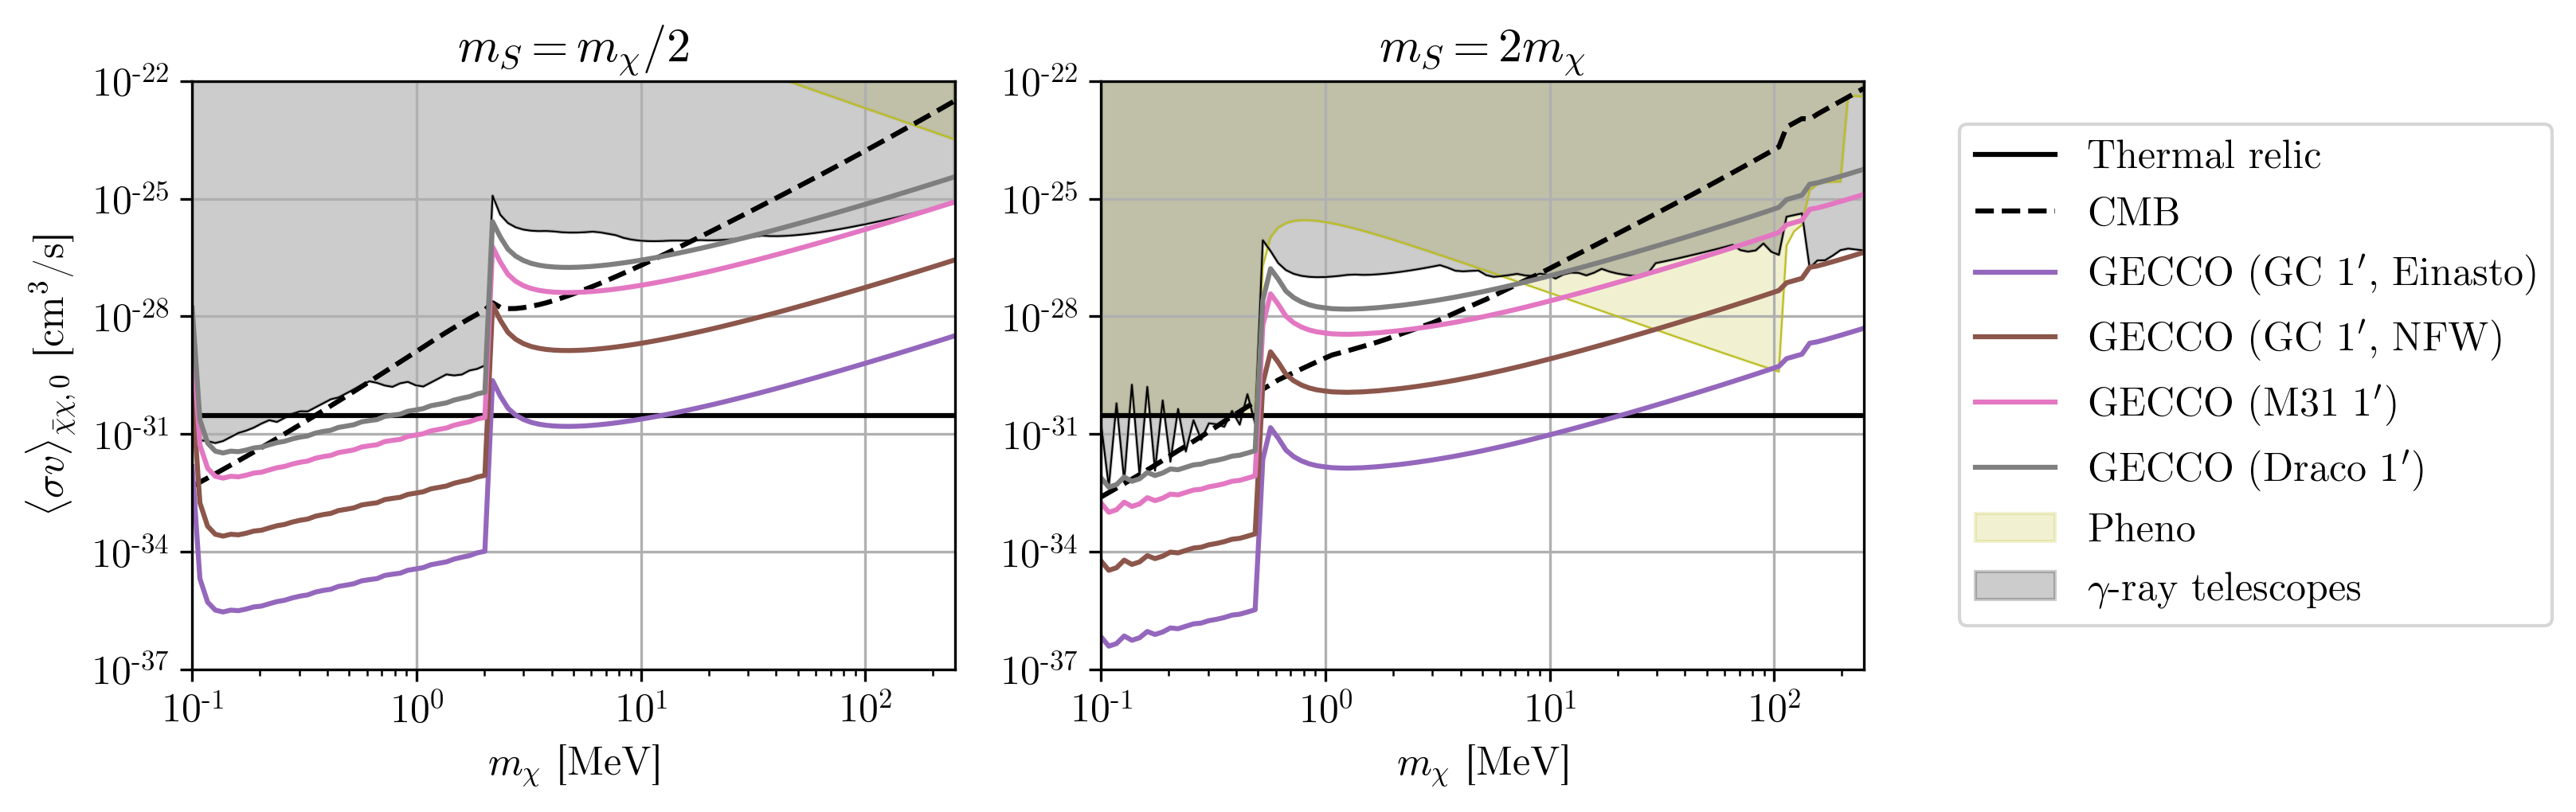

In [475]:
fig, axes = plt.subplots(
    1, len(mxs) + 1, figsize=((len(mxs) + 1) * fig_dim, 0.9 * fig_dim)
)

for i, ax in enumerate(axes[:-1]):
    # Pheno constraint
    svs_pheno = get_svs_pheno(
        hp, mxs[i], mss[i], stheta_pheno, v_mw
    )
    plot_existing(ax, mxs[i], svs_pheno, "Pheno", color)
    
    # Relic cross section, translated to <sigma v> in the Milky Way
    v_fo = np.sqrt(1/10)
    ax.axhline(
        3e-26 * (v_mw / v_fo)**2, linestyle="-", color="k", label="Thermal relic"
    )
    
    # Envelope of existing gamma-ray constraints
    sv_envelope = np.stack(
        [svs[i][k] for k in ["comptel", "fermi", "egret", "integral"]]
    ).min(0)
    plot_existing(ax, mxs[i], sv_envelope, r"$\gamma$-ray telescopes", "k")
    
    # CMB
    v_cmbs = 2e-4 * (0.235) * (1 / mxs[i]) * np.sqrt(1e-4 / x_kd)
    ax.plot(mxs[i], svs[i]["cmb"] * (v_mw / v_cmbs)**2, "--k", label=r"CMB")
    
    # Projections
    for key, color in zip(svs[i], mpl_colors):
        if "gecco" in key:
            ax.loglog(
                mxs[i], svs[i][key], label=get_constraint_label(key), color=color
            )

# Formatting
for i, ax in enumerate(axes[:-1]):
    ax.set_title(titles[i])
    ax.set_xlim(mxs[i][[0, -1]])
    ax.set_ylim(y_lims[i])
    ax.set_xlabel(r"$m_\chi$ [MeV]")
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')

axes[0].set_ylabel(
    r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
)

fig.tight_layout()

# Put a legend below last axis
axes[1].legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3
)

axes[-1].set_visible(False)
axes[1].legend(
    loc="center left", bbox_to_anchor=(1.1, 0.5)
)

fig.savefig("figures/higgs_portal.pdf", bbox_inches="tight")

## Vector
Need to sort out pheno constraints.

In [32]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

In [33]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
np.savez(
    "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
)

# # Load precomputed constraints
# sv_constraints_vms = np.load(
#     "data/sv_constraints_vms.npz", allow_pickle=True
# )["sv_constraints_vms"]

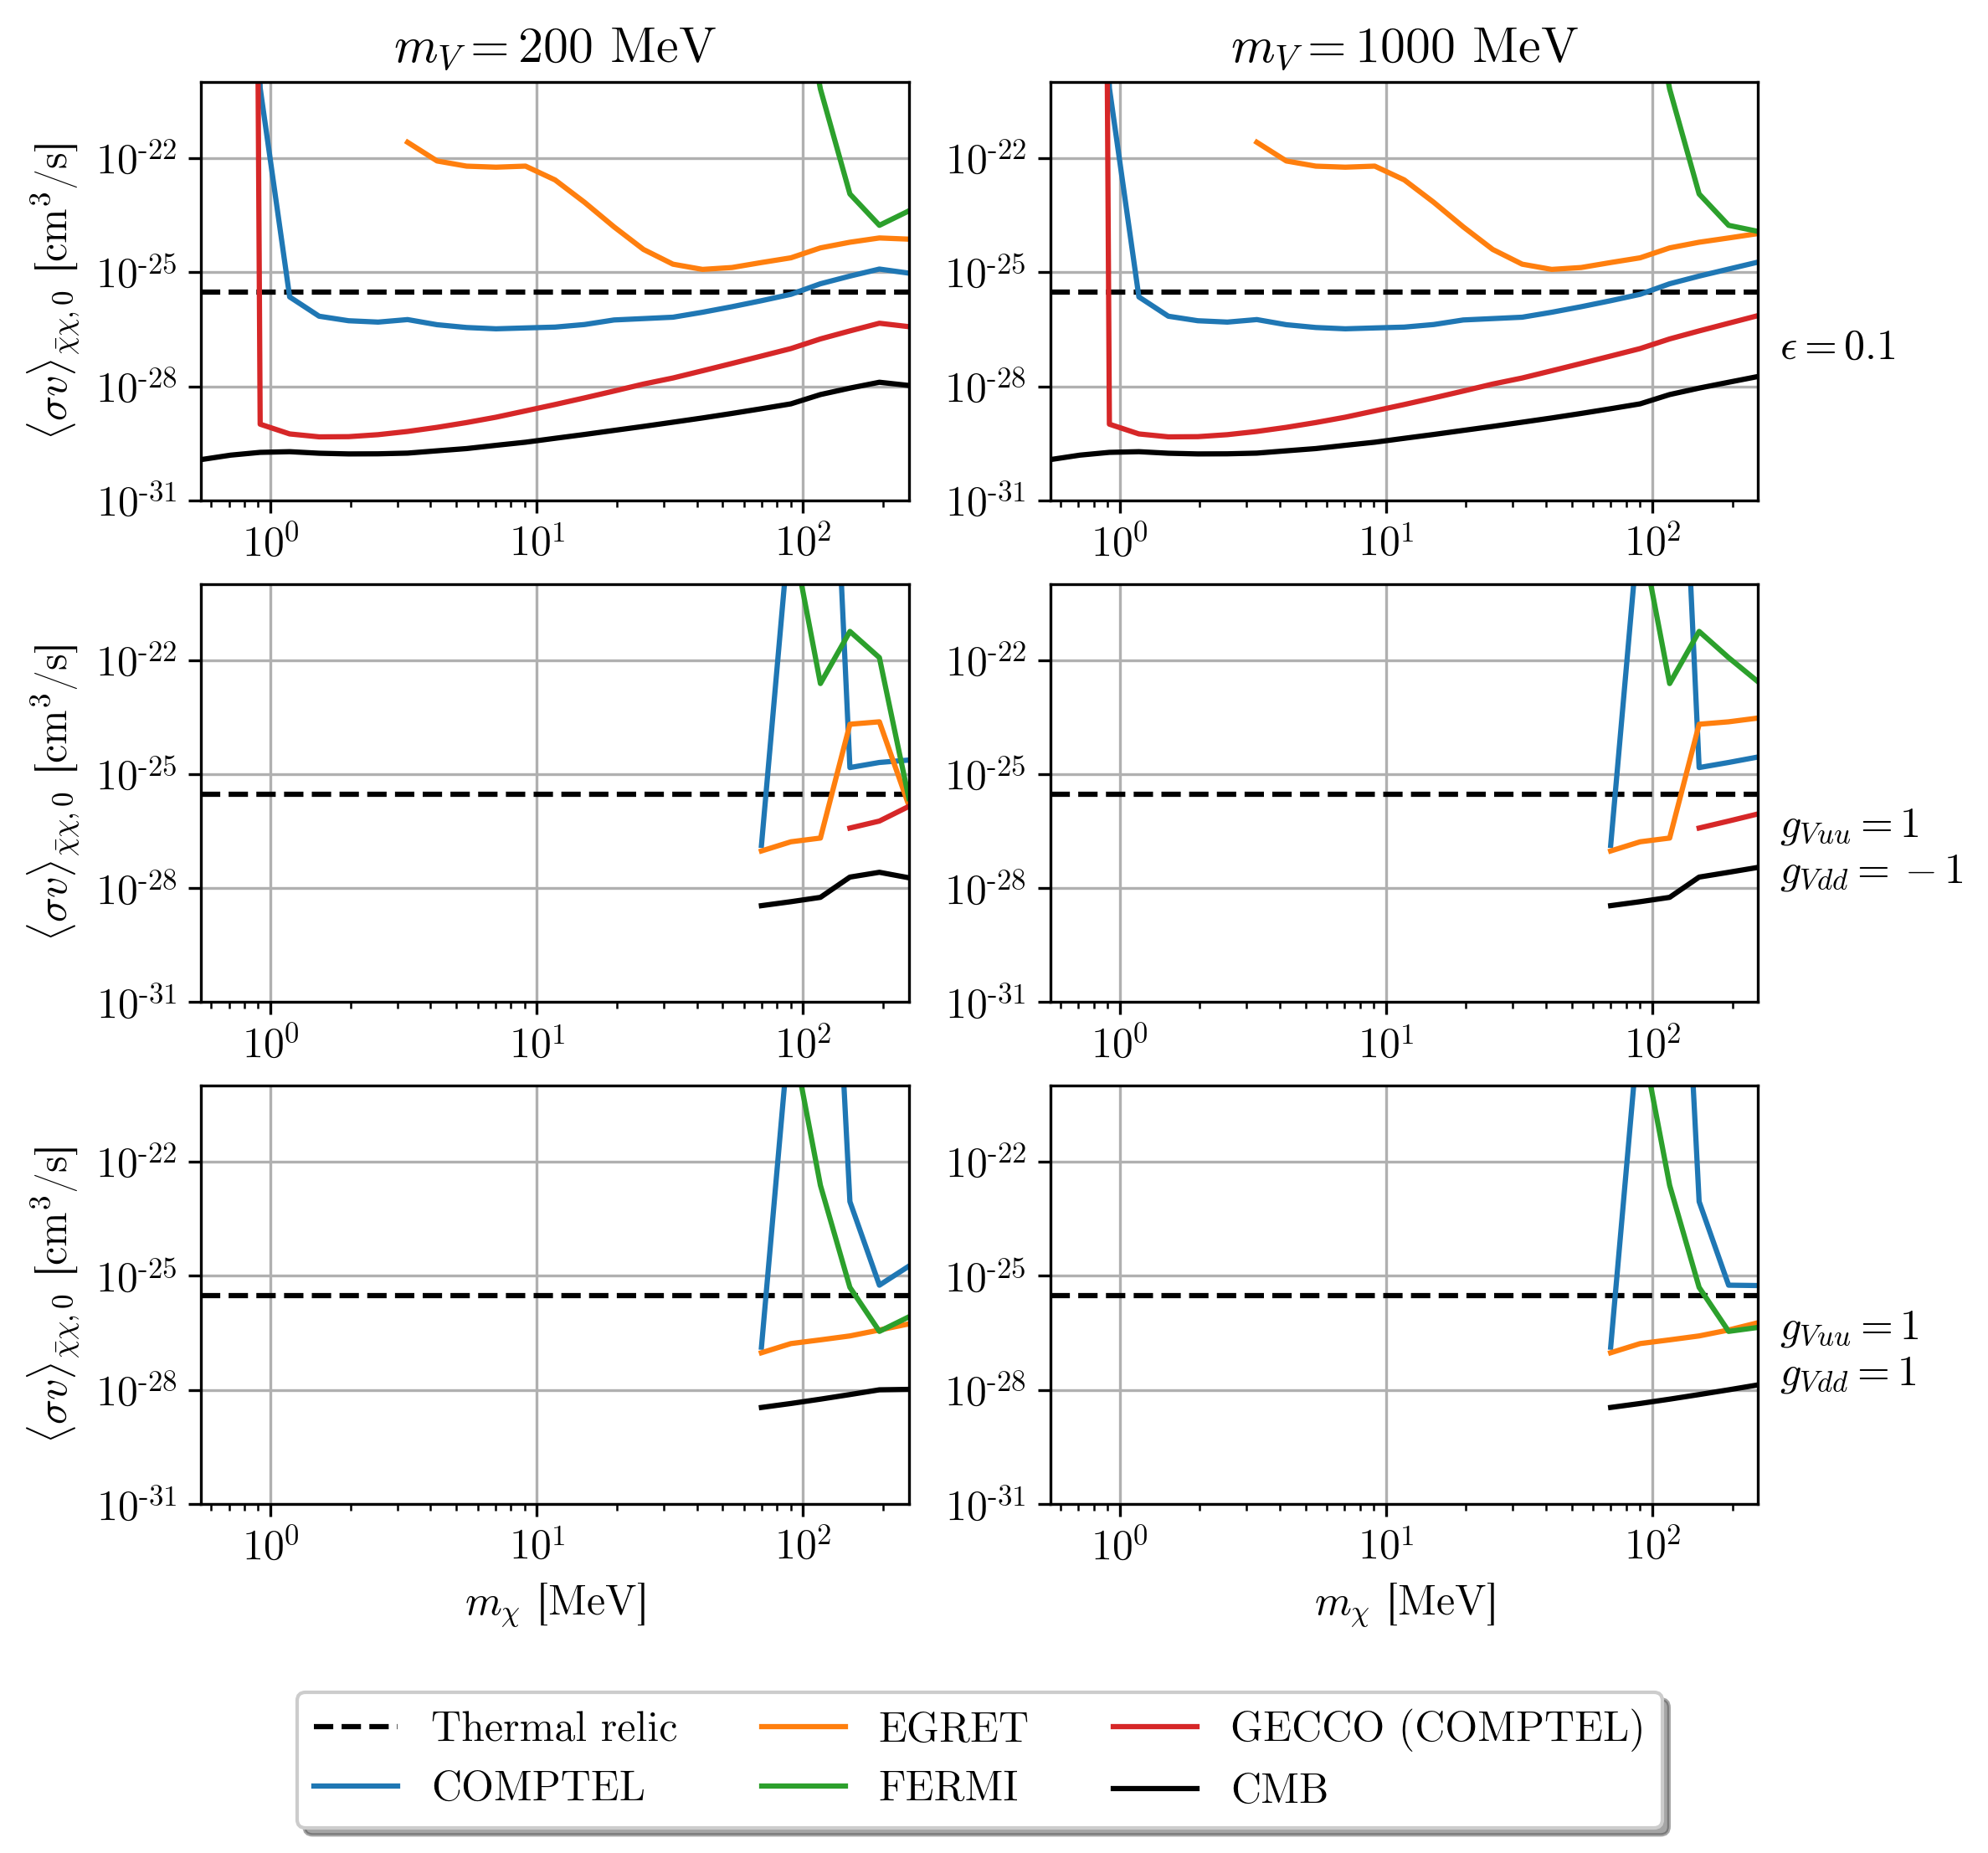

In [36]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm_comptel.png", bbox_inches="tight")

In [38]:
T_obs_nt / 1e6

1.0

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)